# Introduction
This notebook runs inference of the trained model on PASTIS patches to explore the attention weights provided by the model.
Please see the project readme for details on the model and dataset.

This notebook assumes the model has already been trained by running `python -m scripts.train_ltae` and therefore model weights have been saved to `.checkpoints`

In [19]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from data.dataset import SITSDataset
from models.ltae import LTAE  # The model file

pastis_path = "/mnt/c/data/PASTIS-R/PASTIS-R"
device = "cuda"

# Setup
First lets initialize the model and load the best weights

In [14]:
# init model
model = LTAE(
    in_channels=10,  # Adjust according to your dataset
    n_head=8,
    d_k=16,
    mlp3=[256, 128],
    mlp4=[128, 64, 32],
    n_classes=20,
    dropout=0.1,
    d_model=256,
    T=1000
)
model.to(device)

# load weights
model.load_state_dict(torch.load("/mnt/c/repos/am4cm/.checkpoints/best_model_ltae.pth"))

/tmp/ipykernel_769778/459511582.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/mnt/c/repos/am4cm/.checkpoints/best_model_ltae.pth"))

<All keys matched successfully>

We trained on pixels sampled from patches which were flattened. For inference so we can visualise the spatial dimension we need to run inference on complete patches.
To do this we'll won't use the special mini-batch dataset wrapper we used in training, nor a DataLoader, just the base SITSDataset class which loads patches.

First we'll write a helper function which loads patch data, reshapes it, runs model inference and returns the model results and attention weights

In [17]:
def get_predictions(model, pastis_path, fold_id, patch_index):
    """
    Get predictions for a given patch using the specified model.

    Args:
        model (torch.nn.Module): The trained model for making predictions.
        pastis_path (str): The path to the dataset.
        fold_id (int): The fold ID of the dataset.
        patch_index (int): The index of the patch to get predictions for.

    Returns:
        tuple: A tuple containing the features patch labels patch, predicted labels patch, and attention weights patch.
    """
    model.eval()
    model.return_att = True

    # load dataset
    dataset = SITSDataset(pastis_path, fold_id)

    patch = dataset[patch_index]
    labels_flat = patch[1]
    labels_patch = np.reshape(labels_flat, (128, 128))
    features_flat = patch[0]
    features_patch = np.reshape(features_flat, (128, 128, features_flat.shape[1], features_flat.shape[2]))

    with torch.no_grad():
        predictions = model(torch.tensor(patch[0]).float().to(device))

    pred_labels = predictions[0].argmax(dim=1).cpu().numpy()
    pred_att_weights = predictions[1].permute(1,2,0).cpu().numpy()

    # reshape to get back to spatial patch (128x128)
    pred_labels_patch = pred_labels.reshape(128,128)
    pred_att_weights_patch = pred_att_weights.reshape(128, 128, pred_att_weights.shape[1], pred_att_weights.shape[2])

    return features_patch, labels_patch, pred_labels_patch, pred_att_weights_patch

# Results and Analysis

## Crop Classification
Although it isn't the focus of this notebook, lets check the crop classification itself.

In [166]:
# Get the first patch from the evaluation fold (5)
features_patch, labels_patch, pred_labels_patch, pred_att_weights_patch = get_predictions(model, pastis_path, 5, 0)

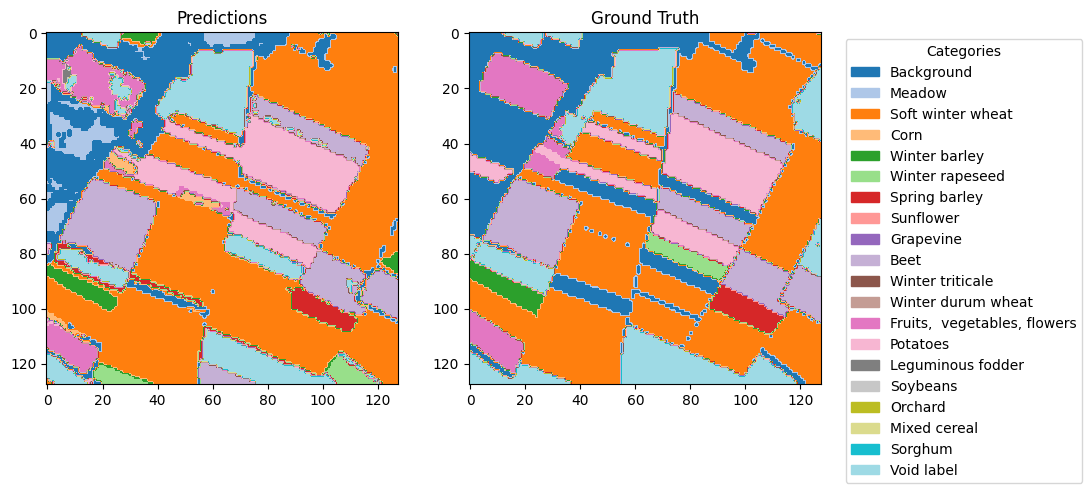

In [167]:
# matplotlib paired imshow of predictions vs y from loaded patch
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(pred_labels_patch, cmap='tab20')

axs[1].imshow(labels_patch, cmap='tab20')

# titles
axs[0].set_title("Predictions")
axs[1].set_title("Ground Truth")

label_path = "/mnt/c/repos/am4cm/src/data/pastis_label_names.json"
with open(label_path, 'r') as f:
    label_names = json.load(f)
labels = label_names.values()

# legend
cmap = plt.get_cmap('tab20')
handles = [plt.Rectangle((0,0),1,1, color=cmap(i)) for i in range(20)]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title="Categories")


That doesn't look bad at all! Obviously some confusions, but the model is doing a great job of pixel-wise classification even though it isn't a spatial model.

## Attention masks

Now lets look at the attention masks/weights produced by the model.

The model produces attention weights per output timestep and per output "head". These heads mean that for any particular time step, the model can learn to "attend" to different things.

Lets start with a helper function to make plotting different timesteps and heads easy.

We'll visualise the RGB image, the attention weights for a particular head (or summed combination of heads), plus optionally apply a threshold to show which pixels are being essentially "masked" out. This will let us experiment with whether we can create a pseudo-cloud mask.

In [134]:
def viz_patch(timestep, heads, threshold=None):
    """
    Visualise the patch in RGB at a given timestep and the attention weights for the specified heads (summed if multiple provided).

    Parameters:
    timestep (int): The timestep of the patch to be plotted.
    heads (int or list): The head(s) for which the attention weights will be plotted. If an integer is provided, only that head will be plotted. If a list is provided, the sum of attention weights will be displayed.

    Returns:
    None
    """
    cols = 3 if threshold else 2
    fig, axs = plt.subplots(1,cols, figsize=(15,8))
    axs[0].imshow(np.clip(features_patch[:, :, timestep, [3,2,1]]*2.5, 0, 1))

    if type(heads) is not list:
        heads = [heads]
    att_weights_prep = pred_att_weights_patch[:,:,timestep, heads].sum(axis=-1)
    axs[1].imshow(np.clip(att_weights_prep, 0, 1), cmap='viridis', vmin=0, vmax=0.1)

    if threshold:
        # display binary mask
        ignore_mask = att_weights_prep < threshold
        axs[2].imshow(np.clip(features_patch[:, :, timestep, [3,2,1]]*2.5, 0, 1))
        axs[2].imshow(np.ma.masked_where(~ignore_mask, np.ones_like(ignore_mask)), cmap='gray', alpha=0.7)
        
    # titles
    axs[0].set_title(f"Timestep {timestep}: RGB")
    axs[1].set_title(f"Attention Weights (yellow = high, purple = low)")
    if threshold:
        axs[2].set_title(f"Thresholded Attention Weights (threshold = {threshold})")



In [135]:
# lets use patch index 1
features_patch, labels_patch, pred_labels_patch, pred_att_weights_patch = get_predictions(model, pastis_path, 5, 1)

### Head 2
Lets look at attention head 2 for a few different timesteps

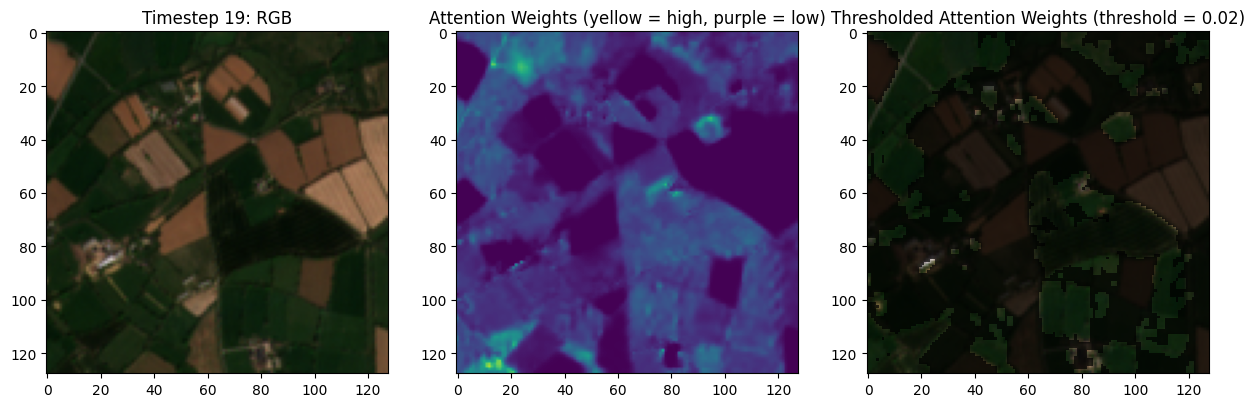

In [136]:
viz_patch(19, 2, threshold=0.02) # timestep 19, head 2, threshold 0.02

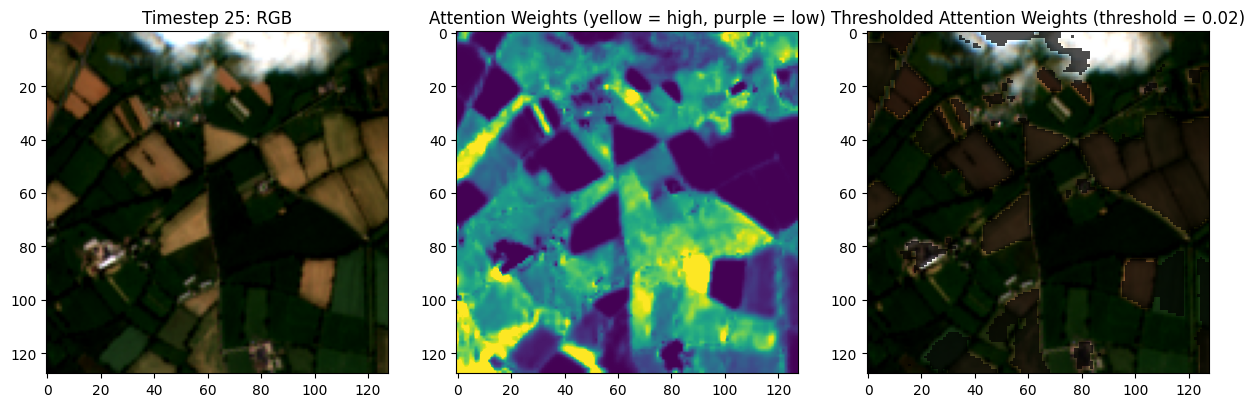

In [137]:
viz_patch(25, 2, threshold=0.02)

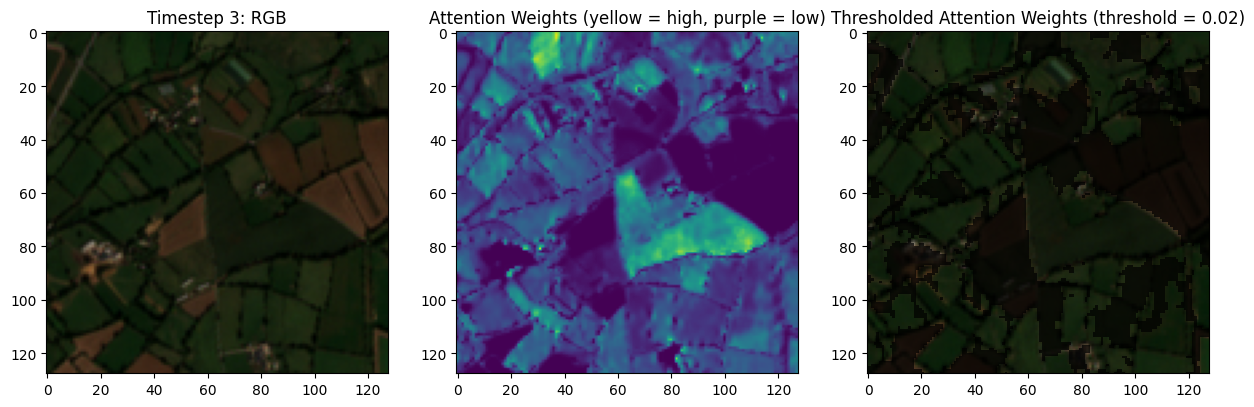

In [138]:
viz_patch(3, 2, threshold=0.02)

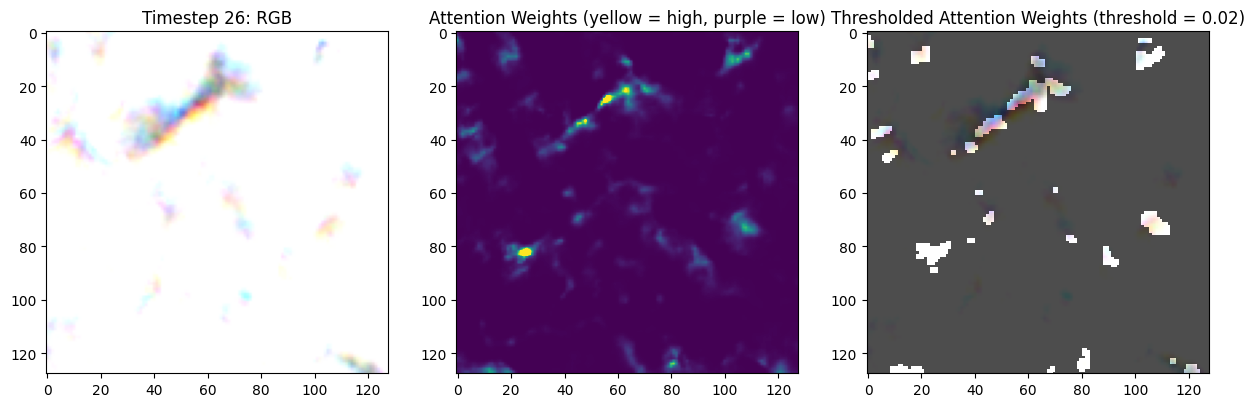

In [139]:
viz_patch(26, 2, threshold=0.02)

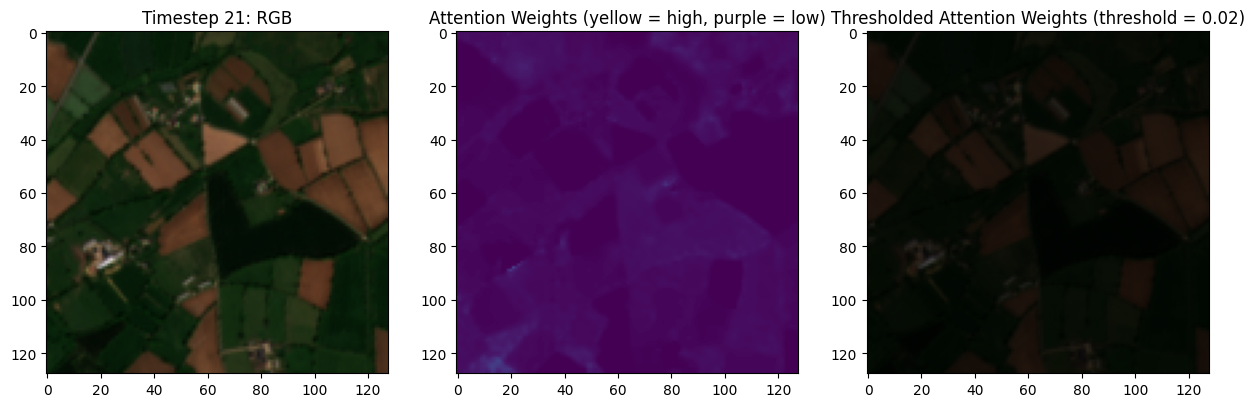

In [140]:
viz_patch(21, 2, threshold=0.02)

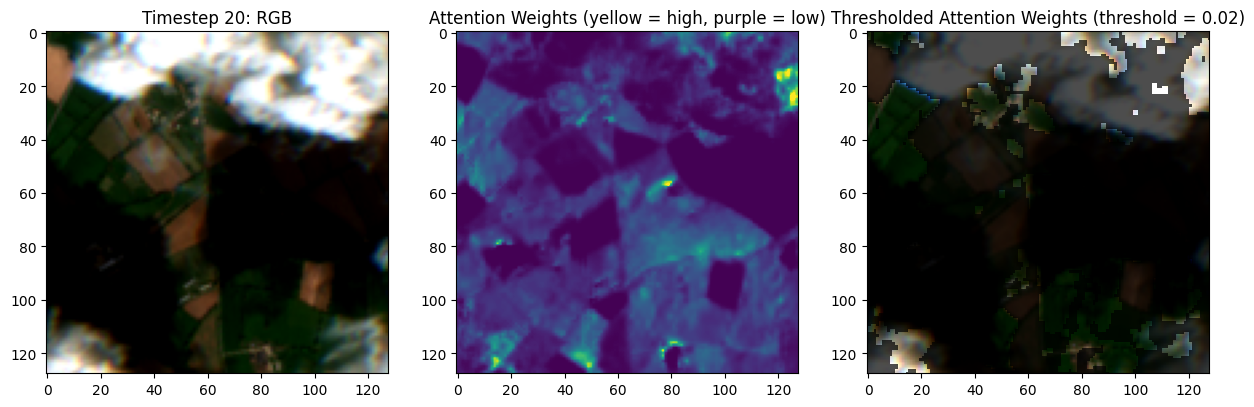

In [141]:
viz_patch(20, 2, threshold=0.02)

Head 2 clearly attends to green pixels in many timesteps, specifically ignoring bare soil. However, it clearly is also time-dependent, ignoring almost all pixels in some timesteps (e.g. 21). Likewise, it tends to ignore cloudy pixels (e.g. 20 and 26), though imperfectly. Furthermore, it doesn't seem to be affected by (cloud) shadowed areas, attending to them in the same way as non-shadowed areas.

### Head 0

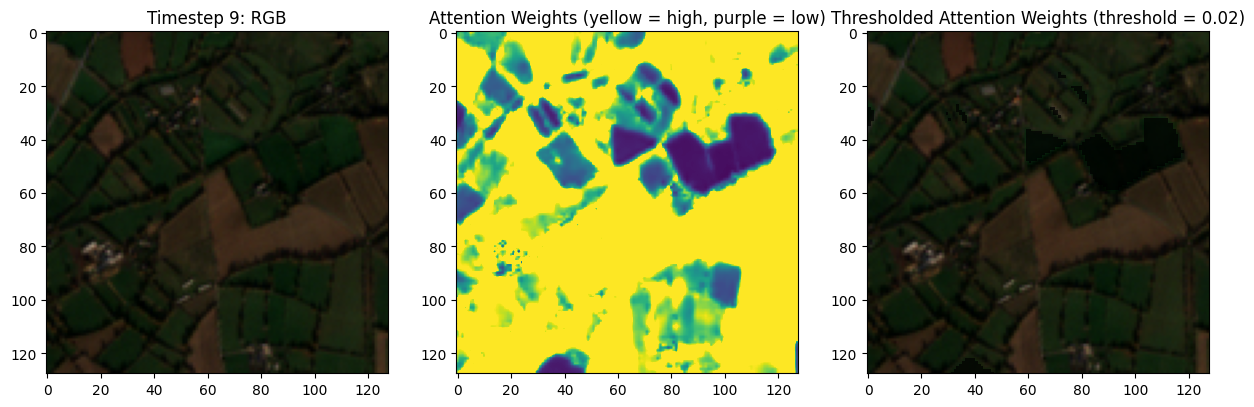

In [144]:
viz_patch(9, 0, threshold=0.02)

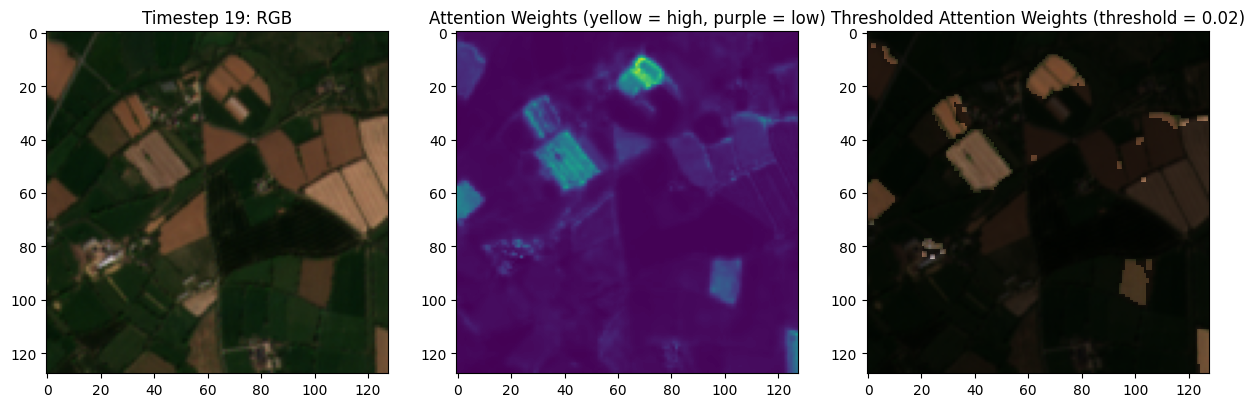

In [142]:
viz_patch(19, 0, threshold=0.02)

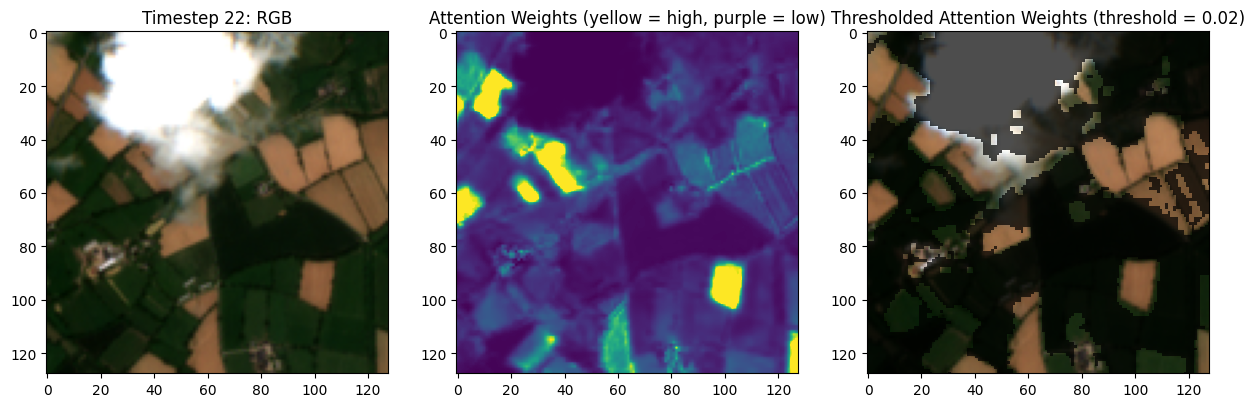

In [145]:
viz_patch(22, 0, threshold=0.02)

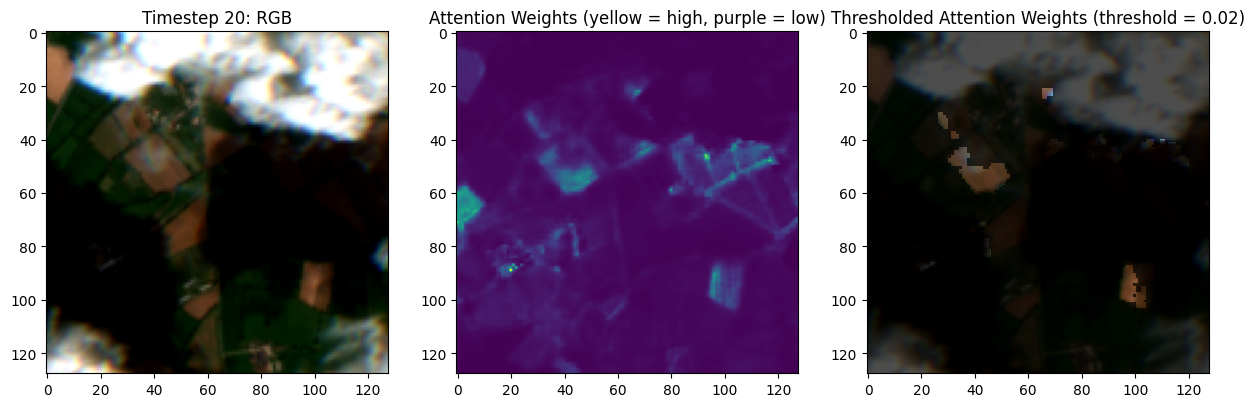

In [146]:
viz_patch(20, 0, threshold=0.02)

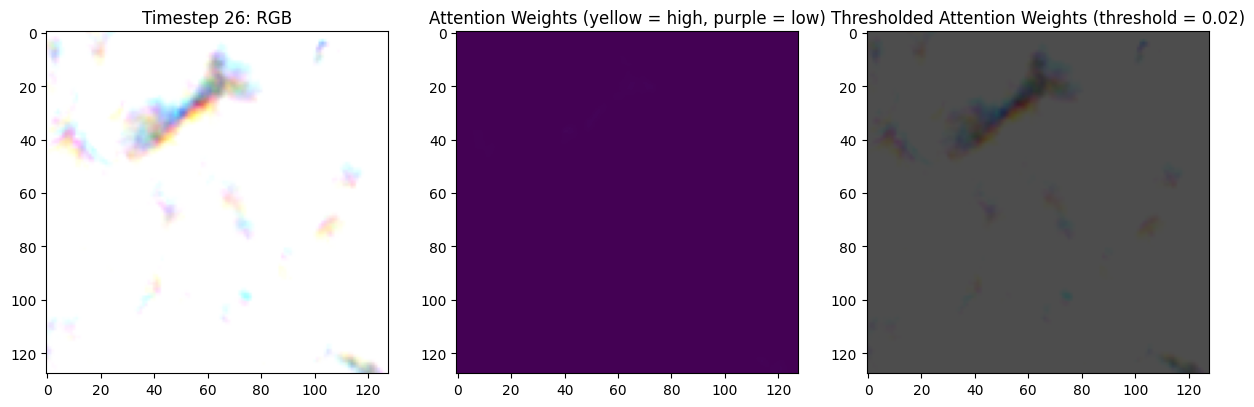

In [147]:
viz_patch(26, 0, threshold=0.02)

Head 0 shows interesting time-dependent behaviour.
At early timesteps (e.g. 9) it attends to many pixels, green or otherwise, though at later timesteps it preferentially attends to bare soil only (e.g. 19, 22). It also generally ignores cloudy pixels (e.g. 20, 22, 26).

### Head 4

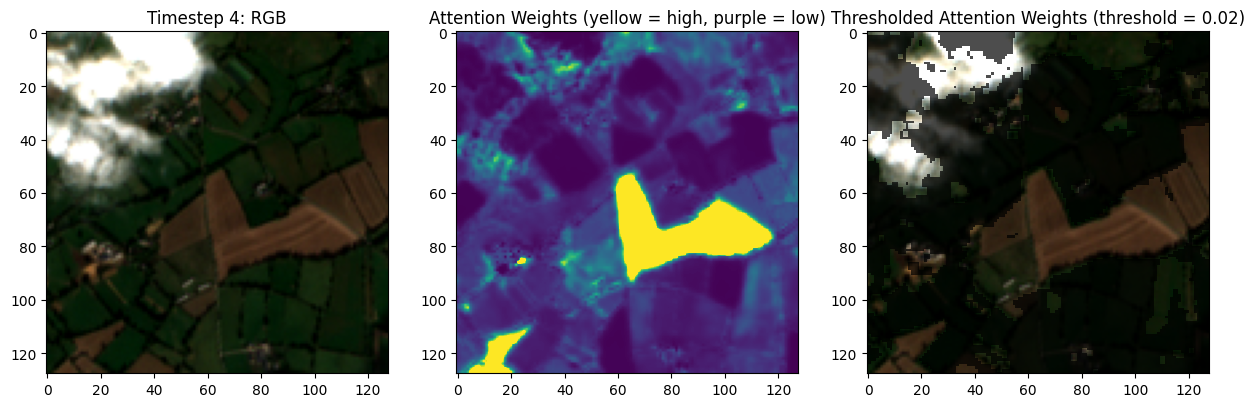

In [161]:
viz_patch(4, 4, threshold=0.02)

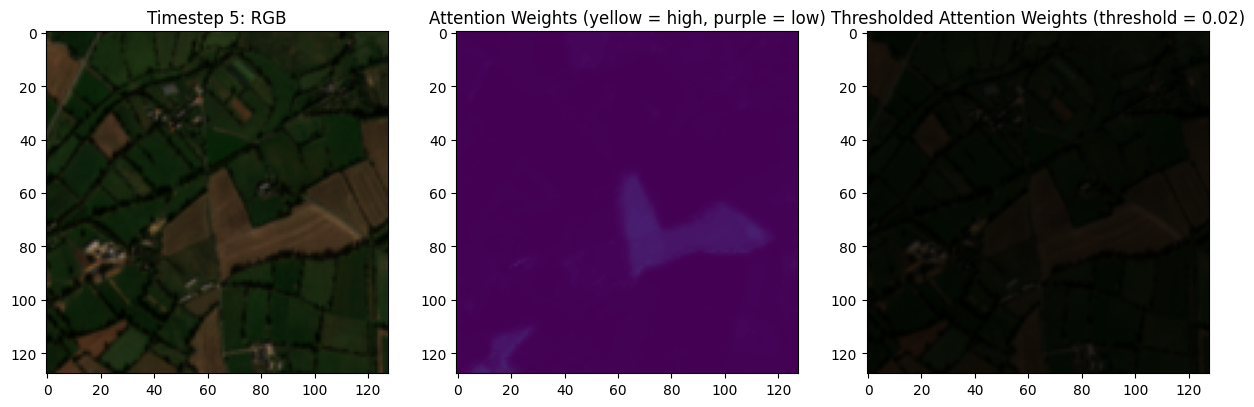

In [158]:
viz_patch(5, 4, threshold=0.02)

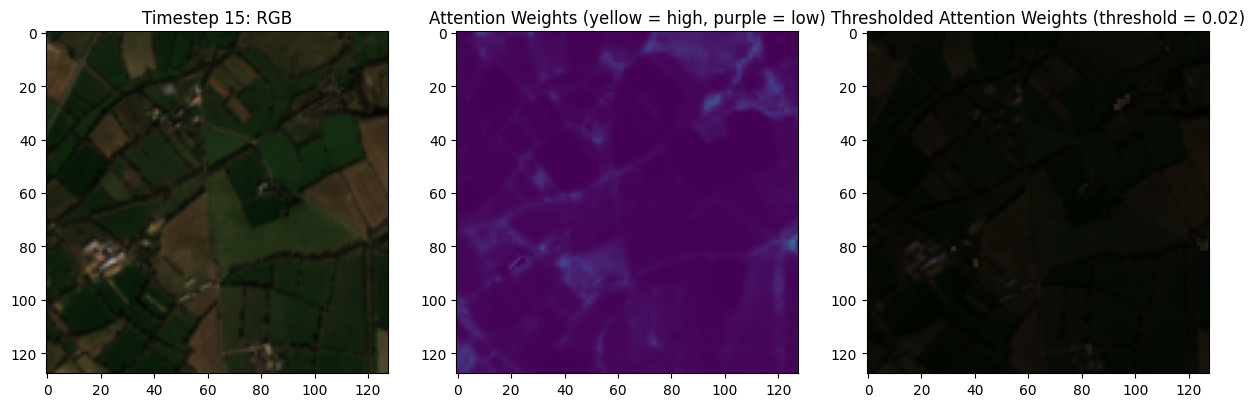

In [159]:
viz_patch(15, 4, threshold=0.02)

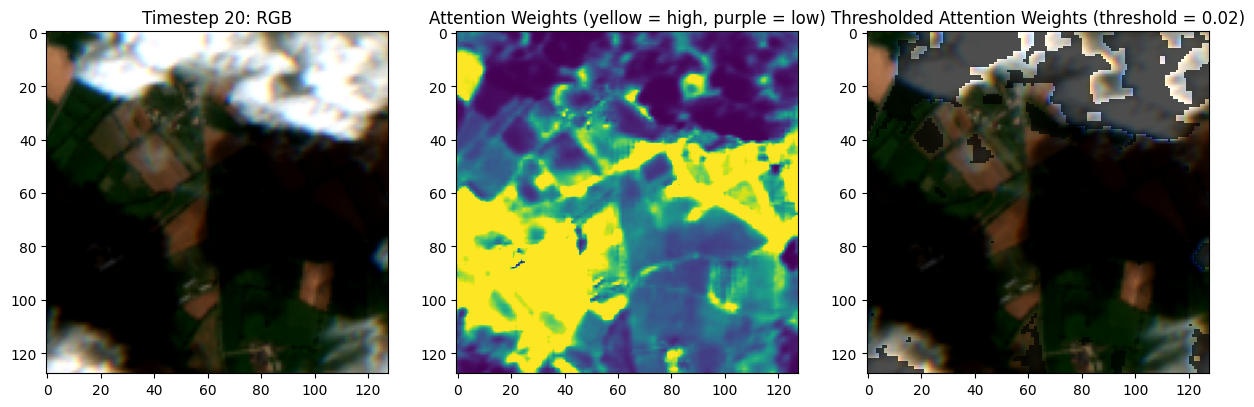

In [143]:
viz_patch(20, 4, threshold=0.02)

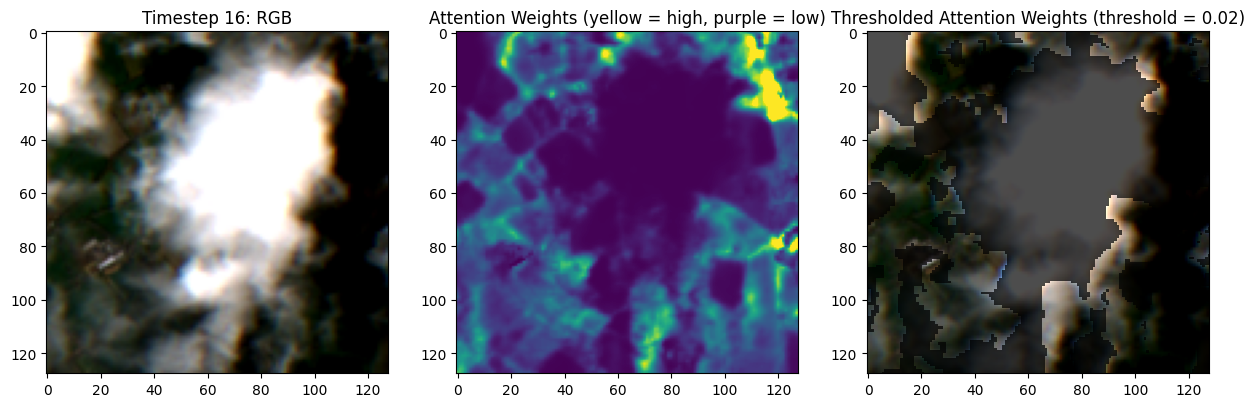

In [160]:
viz_patch(16, 4, threshold=0.02)

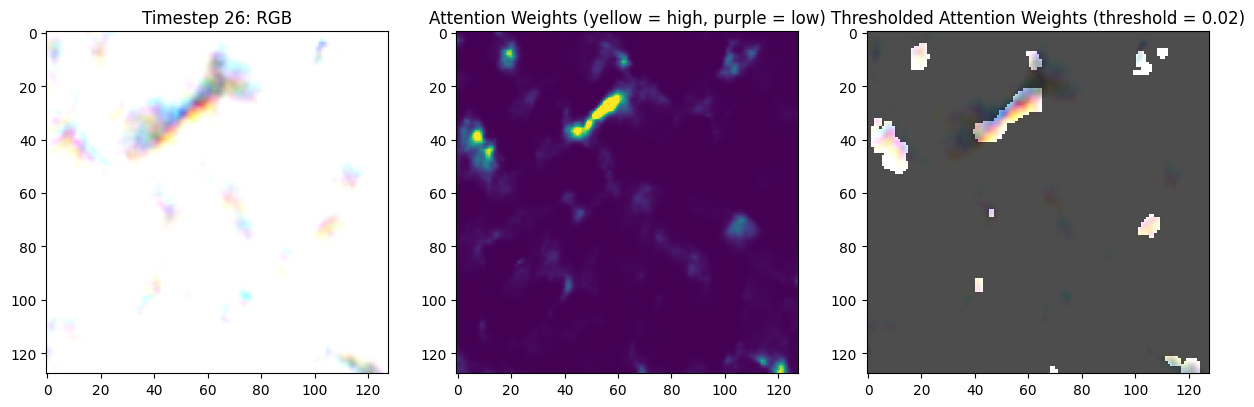

In [163]:
viz_patch(26, 4, threshold=0.02)

The behaviour of head 4 is also highly time dependent. At early time steps, it often doesn't attend to anything, or only bare soil (and clouds) (e.g. 4, 5, 15).
However, at later timesteps, it tends to attend to all pixels except particularly cloudy ones. Therefore, head 4 is the closest to a "cloud mask" of the heads we've looked at, though it is imperfect (including many partially cloudy pixels and cloud edges) and time-dependent.

# Summary and Conclusion

The model, via attention weights, is clearly able to specifically focus on or ignore various pixel types, from green vegetation to bare soil to clouds and cloud shadows. However, the attention weights seem to consider complex temporal dependencies and are not easily and consistently interpretable in all situations. Therefore, while several of the attention heads tend to ignore clouds, while both attending to everything else or only certain non-cloud affected pixel types, the behaviour is not consistent enough to be used as a simple cloud mask. However, given that the model clearly exhibits these kinds of complex behaviours internally, without specific supervision as to particular pixel types (status at different moments in time - soil, vegetation, cloud, etc.), it is likely that this kind of attention based temporal model would be particularly adept at cloud detection if provided a supervised signal for this task.